## Exploring Waveforms

In this contest we're converting audio (`.wav`) files to spectrogram images. There are a number of things I don't understand about this process that I want to investigate:

- What do each of the parameters (`hop_length`, `n_mels` etc.) actually do? How do these parameters affect the images we generate?
- What does the `duration` parameter control? If it's only taking part of the audio file then where do we sample from? The start of the audio? The center? The end?
- Why are the generated images so much smaller than the original audio files?
- When `fastai` loads these images, does it crop them?

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from fastai.vision import Path
import pandas as pd
import matplotlib.pyplot as plt 
import librosa
import librosa.display
from EasyDict import EasyDict
import IPython
import IPython.display
from tqdm import tqdm_notebook
from PIL import Image as pilImage
import os
import sklearn.metrics
from sklearn.preprocessing import MultiLabelBinarizer

In [9]:
DATA = Path('data')
TRN_CURATED = DATA/'train_curated'

CSV_TRN_CURATED = DATA/'train_curated.csv'
CSV_TRN_NOISY = DATA/'train_noisy.csv'

train_df = pd.read_csv(CSV_TRN_CURATED)
train_noisy_df = pd.read_csv(CSV_TRN_NOISY)

In [10]:
def read_audio(conf, pathname, trim_long_data):
    y, _ = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
        
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    elif len(y) * 2 > conf.samples:
        # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    else:
        y = np.pad(y, (1000,1000), 'constant')
        numRepeat = conf.samples // len(y)
        y = np.tile(y, numRepeat)
        #Pad the rest out
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    
    return y


def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram


def show_melspectrogram(conf, mels, title='mfcc'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

    
def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels

## Basic Parameters

We have seven parameters we can control when generating our images:
- **Sampling Rate:** The frequency at which we sample values for our spectrogram. By default the clips are 44.1 kHz.
- **Duration:** The minimum duration for each image file. It does not look like we have been trimming long files. This could be a problem because the same sound will look much different depending on the length of the file it's found within.
- **Hop Length:** From [docs](https://librosa.github.io/librosa/glossary.html): The number of samples between successive frames, e.g., the columns of a spectrogram. This is denoted as a positive integer hop_length.
- **fmin:** The lowest frequency from which to sample
- **fmax:** The highest frequency from which to sample
- **n_mels:** The number of mel bands to generate. Not sure what this means...
- **n_fft:** The number of Fast Fourier Transform components. This appears to be generated by multiplying the `n_mels` parameter by 20. Why 20?

Below are the default parameters for the models we have been training. We'll use them to generate some spectrograms.

In [17]:
conf = EasyDict()

conf.sampling_rate = 32000
conf.duration = 5
conf.hop_length = 500 # So that there are 64 frames per second
conf.fmin = 50
conf.fmax = 14000
conf.n_mels = 128
conf.n_fft = conf.n_mels * 20

conf.samples = conf.sampling_rate * conf.duration

We'll use a 7 second clip of a dog barking and a 0.5 second clip of a drum.

In [23]:
dog_barking_path = TRN_CURATED/'0006ae4e.wav'
drum_path = TRN_CURATED/'fc3472cf.wav'

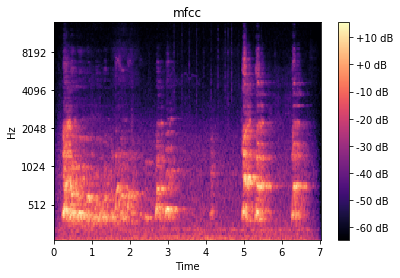

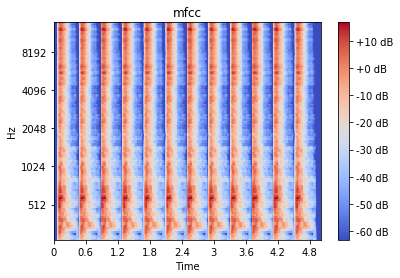

In [24]:
bark = read_as_melspectrogram(conf, dog_barking_path, trim_long_data=False, debug_display=True)
drum = read_as_melspectrogram(conf, drum_path, trim_long_data=False, debug_display=True)